In [409]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [410]:
# Load dataset
file_path = "../../data/ethusd_group_project.csv"
df = pd.read_csv(file_path, parse_dates=['time'])

# Ensure time is sorted
df = df.sort_values(by="time")

# Set time as index
df.set_index('time', inplace=True)

In [189]:
df.head(2)

,open,close,high,low,volume,"RV_d,t",daily_return,"RV_w,t","RV_m,t","ln_RV_d,t","ln_RV_w,t","ln_RV_m,t"
time,,,,,,,,,,,,
2016-03-09,11.197,11.197,11.197,10.660,41.139523,0.014515,NaN,NaN,NaN,-4.232581,NaN,NaN
2016-03-10,11.072,11.750,11.850,11.072,1.030000,0.003658,0.049388,NaN,NaN,-5.610725,NaN,NaN


In [190]:
df.tail(2)

,open,close,high,low,volume,"RV_d,t",daily_return,"RV_w,t","RV_m,t","ln_RV_d,t","ln_RV_w,t","ln_RV_m,t"
time,,,,,,,,,,,,
2023-10-07,1645.5,1634.5,1647.9,1630.5,953.564307,0.000047,-0.006806,0.000688,0.000363,-9.962319,-7.282344,-7.921201
2023-10-08,1634.5,1626.5,1641.2,1625.9,646.669448,0.000027,-0.004894,0.000342,0.000358,-10.506913,-7.981488,-7.935023


### Train-Test Split

In [411]:
# Train-Test Split (80% train, 10% validation, 10% test)
# (daily_return would be the input for GARCH models)

train_size = int(0.8 * len(df))
valid_size = int(0.1 * len(df))

r_train = df.daily_return[:train_size]
r_val = df.daily_return[train_size:train_size+valid_size]
RV_val = df['RV_d,t'][train_size:train_size+valid_size]
r_test = df.daily_return[train_size+valid_size:]
RV_test = df['RV_d,t'][train_size+valid_size:]

In [412]:
r_train.dropna(inplace=True)

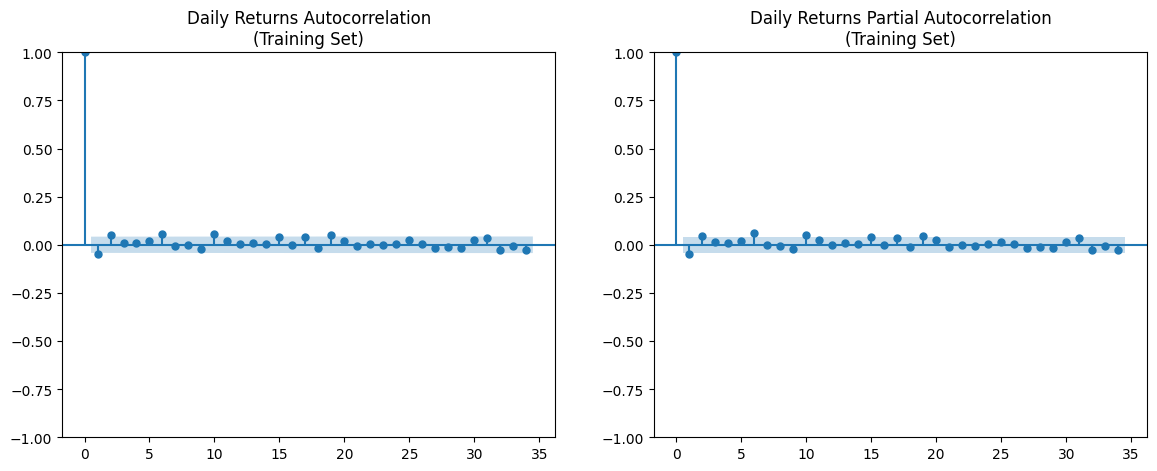

In [413]:
# Visualize the ACF and PACF of the returns
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(r_train, title='Daily Returns Autocorrelation\n(Training Set)', ax=ax[0])
plot_pacf(r_train, title='Daily Returns Partial Autocorrelation\n(Training Set)', ax=ax[1])
plt.show()

### Baseline GARCH(1,1) model

In [414]:
# Fit GARCH(1,1) model to the training set
gm_1 = arch_model(r_train, p=1, q=1, rescale=False)
gm1_fit = gm_1.fit(disp='off')

In [415]:
# Extract GARCH(1,1) parameters
omega = gm1_fit.params['omega']
alpha = gm1_fit.params['alpha[1]']
beta = gm1_fit.params['beta[1]']
print(f"Estimated Parameters: omega={omega:.6f}, alpha={alpha:.6f}, beta={beta:.6f}")

Estimated Parameters: omega=0.000318, alpha=0.100002, beta=0.799998


In [421]:
# Get the last conditional variance from training
last_variance = df['RV_d,t'].iloc[train_size-1]
last_daily_return = r_train.iloc[-1]

# Initialize list for storing predicted volatility (standard deviation)
predicted_volatility = []

# Compute volatility iteratively using GARCH equation
for i in range(len(r_val)):
    r = r_val.iloc[i]
    RV = RV_val.iloc[i]
    new_variance = omega + alpha * (last_daily_return ** 2) + beta * last_variance
    predicted_volatility.append(new_variance)
    # Update for next step
    last_variance = RV  
    last_daily_return = r

In [422]:
# Calculate Error Metrics
mse = mean_squared_error(RV_val, predicted_volatility)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(RV_val, predicted_volatility)
r2 = r2_score(RV_val, predicted_volatility)

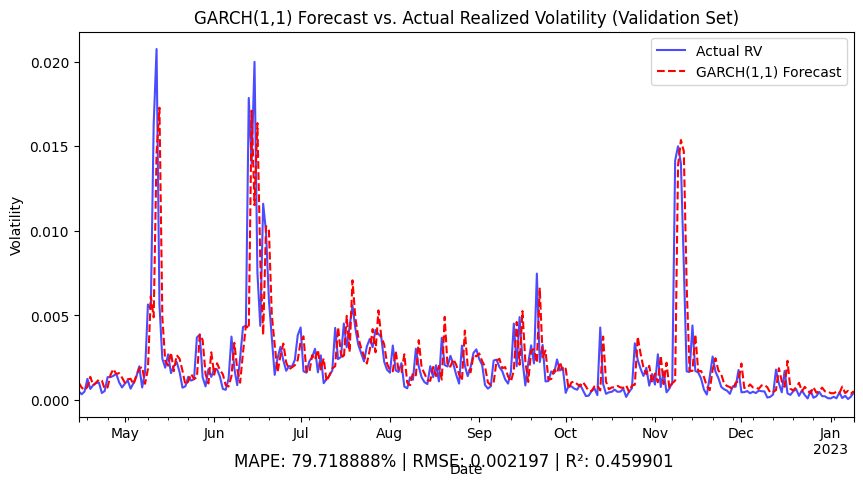

In [425]:
# Create a DataFrame for visualization
df_pred = pd.DataFrame({'Predicted Volatility': predicted_volatility}, index=r_val.index)

# Plot the predicted volatility against the realized volatility on the validation set
plt.figure(figsize=(10, 5))
RV_val.plot(label="Actual RV", color="blue", alpha=0.7)
df_pred['Predicted Volatility'].plot(label="GARCH(1,1) Forecast", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("GARCH(1,1) Forecast vs. Actual Realized Volatility (Validation Set)")
plt.legend()
#add captions
plt.figtext(0.5, 0.01, f"MAPE: {mape:.6%} | RMSE: {rmse:.6f} | R²: {r2:.6f}", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

### Optimise p and q based on MSE

In [441]:
# Store results
MSE_results = []

In [442]:
# Define range of p and q values to test
p_range = range(1, 5)
q_range = range(1, 5)

# Loop over all (p, q) combinations
for p in p_range:
    for q in q_range:
        predicted_volatility = []

        # Get the last conditional variance from training
        last_daily_returns = r_train[train_size-p-1:train_size-1]
        last_variances = df['RV_d,t'].iloc[train_size-q:train_size]
        
        try:
            model = arch_model(r_train, vol='Garch', p=p, q=q, rescale=False)
            garch_fit = model.fit(disp="off")
            params = garch_fit.params
            omega = params['omega']
            alpha = [params[f'alpha[{i+1}]'] for i in range(p)]
            beta = [params[f'beta[{i+1}]'] for i in range(q)]

            # Compute volatility iteratively using GARCH equation
            for j in range(len(r_val)):
                r = r_val.iloc[j]
                RV = RV_val.iloc[j]               
                new_variance = omega
                for i in range(p):
                    new_variance += alpha[i] * (last_daily_returns.iloc[-(1+i)] ** 2)
                for i in range(q):
                    new_variance += beta[i] * last_variances.iloc[-(1+i)]
                predicted_volatility.append(new_variance)
                # Update for next step
                last_variances = last_variances.shift(-1)  # Moves all values left
                last_variances.iloc[-1] = RV
                last_daily_returns = last_daily_returns.shift(-1)
                last_daily_returns.iloc[-1] = r 

            # Compute MSE
            mse = mean_squared_error(RV_val, predicted_volatility)
            MSE_results.append((p, q, mse))

        except Exception as e:
            print(f"Skipping GARCH({p},{q}) due to error: {e}")

In [443]:
# Convert results to a DataFrame
gm_results = pd.DataFrame(MSE_results, columns=['p', 'q', 'MSE'])

# Find the best (p, q) with the lowest MSE
best_params = gm_results.loc[gm_results['MSE'].idxmin()]
best_p = best_params['p']
best_q = best_params['q']
best_mse = best_params['MSE']
print(f"Best GARCH({best_p},{best_q}) model with MSE={best_mse:.6f}")


Best GARCH(2.0,1.0) model with MSE=0.000005


### Best GARCH Model

In [444]:
p = 2
q = 1

In [445]:
# Fit Best GARCH model to the training set
gm_best = arch_model(r_train, p=p, q=q, rescale=False)
gm_best_fit = gm_best.fit(disp='off')

In [446]:
# Extract GARCH(3,2) parameters
omega = params['omega']
alpha = [params[f'alpha[{i+1}]'] for i in range(p)]
beta = [params[f'beta[{i+1}]'] for i in range(q)]
print(f"Estimated Parameters: \nomega={omega:.6f}, \nalpha={alpha}, \nbeta={beta}")

Estimated Parameters: 
omega=0.000533, 
alpha=[0.1537673092729178, 0.06435415396206072], 
beta=[2.6730845060803973e-17]


In [447]:
# Get the last conditional variance from training
last_daily_returns = r_train[train_size-p-1:train_size-1]
last_variances = df['RV_d,t'].iloc[train_size-q:train_size]

In [448]:
# Initialize list for storing predicted volatility (standard deviation)
predicted_volatility = []

# Compute forcase volatility on the test set
for j in range(len(r_test)):
    r = r_test.iloc[j]
    RV = RV_test.iloc[j]
    new_variance = omega
    for i in range(p):
        new_variance += alpha[i] * (last_daily_returns.iloc[-(1+i)] ** 2)
    for i in range(q):
        new_variance += beta[i] * last_variances.iloc[-(1+i)]
    predicted_volatility.append(new_variance)
    # Update for next step
    last_variances = last_variances.shift(-1)
    last_variances.iloc[-1] = RV
    last_daily_returns = last_daily_returns.shift(-1)
    last_daily_returns.iloc[-1] = r 

In [449]:
# Calculate Error Metrics
mse = mean_squared_error(RV_test, predicted_volatility)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(RV_test, predicted_volatility)
r2 = r2_score(RV_test, predicted_volatility)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.6%}")
print(f"R² Score: {r2:.6f}")

Mean Squared Error (MSE): 0.000001
Root Mean Squared Error (RMSE): 0.000714
Mean Absolute Percentage Error (MAPE): 223.135219%
R² Score: 0.009915


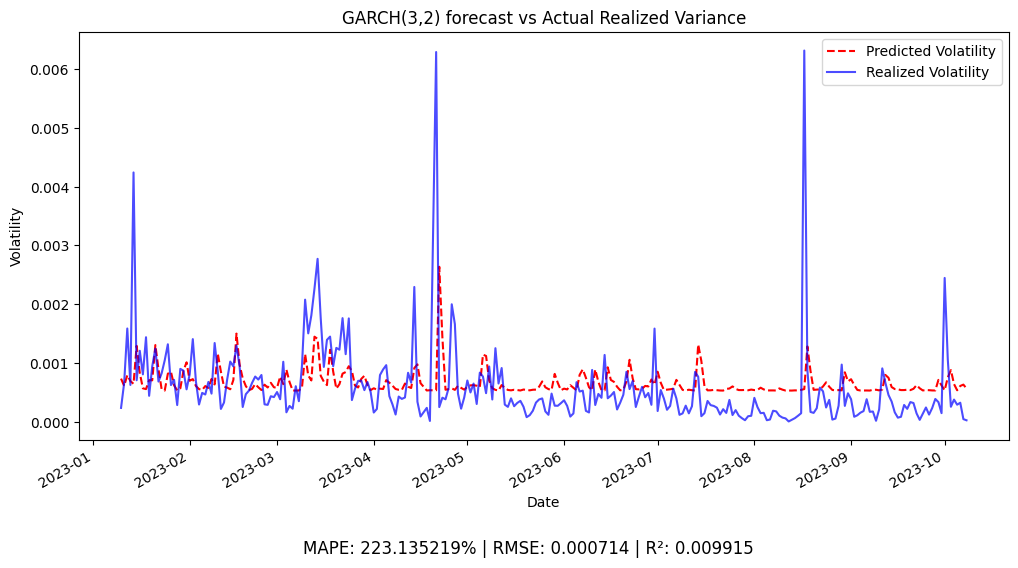

In [450]:
# Create a DataFrame for visualization
df_pred = pd.DataFrame({'Predicted Volatility': predicted_volatility}, index=r_test.index)

# Plot the predicted volatility against the realized volatility on the test set
plt.figure(figsize=(12, 6))
df_pred['Predicted Volatility'].plot(label='Predicted Volatility', color="red", linestyle="dashed")
RV_test.plot(label='Realized Volatility', color="blue", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("GARCH(3,2) forecast vs Actual Realized Variance")
plt.legend()
#add captions
plt.figtext(0.5, 0.01, f"MAPE: {mape:.6%} | RMSE: {rmse:.6f} | R²: {r2:.6f}", wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'../../results/figures/GARCH({p}, {q})_plot.png')
plt.show()